<a href="https://colab.research.google.com/github/chueneelvin/Databricks/blob/main/dental_clinic_ai_assistant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install required packages

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain langchain-core langchain-community langchain_groq langchain_core langgraph jp sentence-transformers faiss-cpu

# Import the required packages

In [2]:
import os
from langchain.document_loaders import JSONLoader
import json
from pathlib import Path
from pprint import pprint
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.vectorstores import Pinecone
from langchain.vectorstores import FAISS

# Set up the environmen variable

In [3]:
# Get the API key from user data
from google.colab import userdata
os.environ['PINECONE_API_KEY'] = userdata.get('PINECONE_API_KEY')
os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY') # https://console.groq.com/keys

# Set up LangSmith for tracing
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_API_KEY'] = userdata.get('LANGCHAIN_API_KEY')
os.environ['LANGCHAIN_PROJECT'] = 'assistant'

# Create tools

## Retriver Tool (FAQs and Policies)

### Load the FAQs

In [4]:
#Load the FAQs data
file_path='/content/FAQ.json'
docs = json.loads(Path(file_path).read_text())

### Text Chunking

In [5]:
# Load the FAQs data
file_path='/content/FAQ.json'
docs = json.loads(Path(file_path).read_text())

# Convert the list of dictionaries to a list of Document objects
from langchain.schema import Document
docs = [Document(page_content=str(doc)) for doc in docs]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=150,
    length_function=len
)

chunked_docs = text_splitter.split_documents(docs)
len(chunked_docs)

28

In [6]:
chunked_docs[26]

Document(metadata={}, page_content="{'question': 'What should I expect during my first visit?', 'answer': 'During your first visit, we will review your medical and dental history, take X-rays, and perform a comprehensive exam. We will then discuss your treatment options and answer any questions you may have.'}")

### Embedding model

In [7]:
from langchain.embeddings import HuggingFaceEmbeddings

# Get the Hugging Face token from user data
hf_token = userdata.get('HF_TOKEN')

# Create embeddings using the specified model
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2", cache_folder ="/content/embeddings")
print('embedding model initialized')

/usr/local/lib/python3.10/dist-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in HuggingFaceInferenceAPIEmbeddings has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
<ipython-input-7-7629d35582ab>:7: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2", cache_folder ="/content/embeddings")
/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

embedding model initialized


In [8]:
faiss_db = FAISS.from_documents(chunked_docs, embeddings)
faiss_db

In [13]:
from langchain_groq import ChatGroq
llm = ChatGroq(temperature=0, model_name="llama3-70b-8192")
llm


ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x78d85dcefac0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x78d85dcee3e0>, model_name='llama3-70b-8192', temperature=1e-08, model_kwargs={}, groq_api_key=SecretStr('**********'))

In [10]:
retriever = faiss_db.as_retriever()

### Create a retriever tool

In [11]:
#create a retriver tool
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "answer_frequently_asked_questions",
    "Useful for answering questions about the FAQs. Input should be a fully formed question"
   ,
)

# Check Doctor Availability Tool

In [38]:
import pandas as pd

def check_availability_by_doctor(desired_date:DateModel, doctor_name:Literal['kevin anderson','robert martinez','susan davis','daniel miller','sarah wilson','michael green','lisa brown','jane smith','emily johnson','john doe']):
    """
    Checking the database if we have availability for the specific doctor.
    The parameters should be mentioned by the user in the query
    """
    #Dummy data
    df = pd.read_csv("/content/availability.csv")
    df['date_slot_time'] = df['date_slot'].apply(lambda input: input.split(' ')[-1])
    rows = list(df[(df['date_slot'].apply(lambda input: input.split(' ')[0]) == desired_date.date)&(df['doctor_name'] == doctor_name)&(df['is_available'] == True)]['date_slot_time'])

    if len(rows) == 0:
        output = "No availability in the entire day"
    else:
        output = f'This availability for {desired_date.date}\n'
        output += "Available slots: " + ', '.join(rows)

    return output

NameError: name 'DateModel' is not defined

In [39]:
import pandas as pd
from datetime import date # import the date object from datetime

def check_availability_by_doctor(desired_date:date, doctor_name:Literal['kevin anderson','robert martinez','susan davis','daniel miller','sarah wilson','michael green','lisa brown','jane smith','emily johnson','john doe']): # Use date instead of DateModel
    """
    Checking the database if we have availability for the specific doctor.
    The parameters should be mentioned by the user in the query
    """
    #Dummy data
    df = pd.read_csv("/content/availability.csv")
    df['date_slot_time'] = df['date_slot'].apply(lambda input: input.split(' ')[-1])
    rows = list(df[(df['date_slot'].apply(lambda input: input.split(' ')[0]) == desired_date.strftime('%Y-%m-%d'))&(df['doctor_name'] == doctor_name)&(df['is_available'] == True)]['date_slot_time']) # Convert date to string for comparison

    if len(rows) == 0:
        output = "No availability in the entire day"
    else:
        output = f'This availability for {desired_date.strftime("%Y-%m-%d")}\n' # Convert date to string for output
        output += "Available slots: " + ', '.join(rows)

    return output

NameError: name 'Literal' is not defined

In [41]:
#!pip install typing_extensions
import pandas as pd
from datetime import date
from typing_extensions import Literal #Import Literal from typing_extensions

def check_availability_by_doctor(desired_date:date, doctor_name:Literal['kevin anderson','robert martinez','susan davis','daniel miller','sarah wilson','michael green','lisa brown','jane smith','emily johnson','john doe']): # Use date instead of DateModel
    """
    Checking the database if we have availability for the specific doctor.
    The parameters should be mentioned by the user in the query
    """
    #Dummy data
    df = pd.read_csv("/content/availability.csv")
    df['date_slot_time'] = df['date_slot'].apply(lambda input: input.split(' ')[-1])
    rows = list(df[(df['date_slot'].apply(lambda input: input.split(' ')[0]) == desired_date.strftime('%Y-%m-%d'))&(df['doctor_name'] == doctor_name)&(df['is_available'] == True)]['date_slot_time']) # Convert date to string for comparison

    if len(rows) == 0:
        output = "No availability in the entire day"
    else:
        output = f'This availability for {desired_date.strftime("%Y-%m-%d")}\n' # Convert date to string for output
        output += "Available slots: " + ', '.join(rows)

    return output

# List all the tools

In [42]:
tools = [retriever_tool, check_availability_by_doctor]

# Bind the tools to LLM

In [43]:
llm_with_tools = llm.bind_tools(tools)
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x78d85dcefac0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x78d85dcee3e0>, model_name='llama3-70b-8192', temperature=1e-08, model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'answer_frequently_asked_questions', 'description': 'Useful for answering questions about the FAQs. Input should be a fully formed question', 'parameters': {'properties': {'query': {'description': 'query to look up in retriever', 'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'check_availability_by_doctor', 'description': 'Checking the database if we have availability for the specific doctor.\nThe parameters should be mentioned by the user in the query', 'parameters': {'properties': {'desired_date': {'format': 'date', 'type': 'string'}, 'doctor_name': {'enum': ['kevin a

# Assistant Node

In [23]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with answering frequently asked questions.Do not respond directly without using a tool instead reply with : Please send your query to chuene95@gmail.com")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Build the Graph

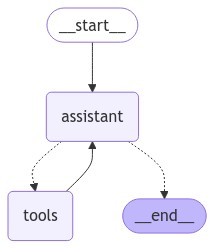

In [44]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [47]:
messages = [HumanMessage(content="Do you open on Christmas day?")]
messages = react_graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Do you open on Christmas day?
================================== Ai Message ==================================
Tool Calls:
  answer_frequently_asked_questions (call_0c1d)
 Call ID: call_0c1d
  Args:
    query: Do you open on Christmas day?
================================= Tool Message =================================
Name: answer_frequently_asked_questions

{'question': 'When is the clinic open?', 'answer': 'We are open Monday through Friday from 8:00 AM to 5:00 PM, and Saturday from 9:00 AM to 1:00 PM. We are closed on Sundays and major holidays.'}

{'question': 'Do you offer teeth whitening?', 'answer': 'Yes, we offer both in-office and take-home teeth whitening options.'}

{'question': 'Do you offer discounts for senior citizens or students?', 'answer': 'No'}

{'question': 'Do you offer emergency dental services?', 'answer': 'Yes, we offer emergency dental services during our regular operating hours.